# Imports

In [13]:
import glob
import librosa
import os
import pandas as pd
import matplotlib.pyplot as plt
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import soundfile as sf
import numpy as np

# Paths

In [8]:
DATA_PATH = "./ICBHI_final_database/"
ANNOTATION_PATH="annotation.csv"
ANNOTATION="annotation.csv"
PREPROCESSED_DATA_PATH="./ICBHI_final_database_preprocessed"
PREPROCESSED_NORMALIZED_DATA_PATH="./ICBHI_final_database_preprocessed_normalized"

# Data Exploration

### Class Distribution

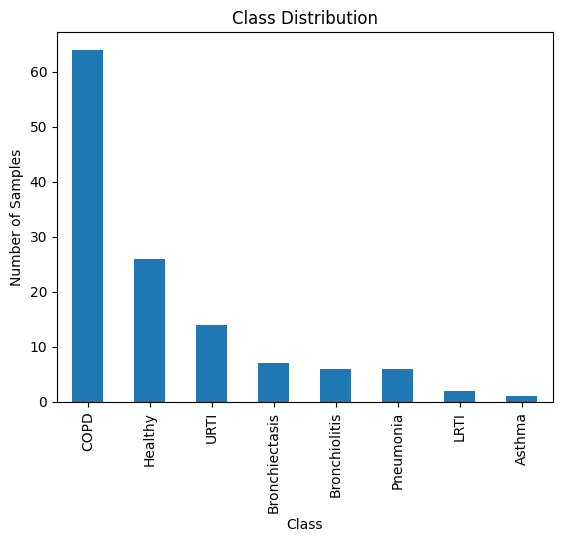

In [4]:
# Load annotations
annotations = pd.read_csv(os.path.join(DATA_PATH,ANNOTATION_PATH))

# Count occurrences of each label
label_counts = annotations['label'].value_counts()

# Plot the distribution
label_counts.plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()


As we see here the COPD is dominating all the other classes by far which is a problem so we need to find a solution for this but before let's be sure that the labels aren't well distributed in the length of audios

In [4]:
from collections import defaultdict
# Dictionnaire pour accumuler les durées
durations = defaultdict(float)

# Itérer sur toutes les lignes
for _, row in annotations.iterrows():
    prefix= str(row['id'])
    matching_files = []
    
    for root, dirs, files in os.walk(DATA_PATH):
        for file in files:
            if file.endswith('.wav') and file.startswith(prefix):
                matching_files.append(os.path.join(root, file))
    for file in matching_files:
        # Vérifier que le fichier existe
        if os.path.exists(file):
            try:
                # Charger l'audio pour obtenir la durée
                audio, sr = librosa.load(file, sr=None)
                duration = librosa.get_duration(y=audio, sr=sr)
                # Ajouter à la classe correspondante
                durations[row['label']] += duration
            except Exception as e:
                print(f"Erreur avec le fichier {file}: {e}")

# Afficher les durées totales par classe
for label, total_duration in durations.items():
    print(f"Classe '{label}' : {total_duration:.2f} secondes ({total_duration / 60:.2f} minutes)")

Classe 'URTI' : 459.65 secondes (7.66 minutes)
Classe 'Healthy' : 699.54 secondes (11.66 minutes)
Classe 'Asthma' : 20.00 secondes (0.33 minutes)
Classe 'COPD' : 17233.84 secondes (287.23 minutes)
Classe 'LRTI' : 40.00 secondes (0.67 minutes)
Classe 'Bronchiectasis' : 320.00 secondes (5.33 minutes)
Classe 'Pneumonia' : 740.00 secondes (12.33 minutes)
Classe 'Bronchiolitis' : 260.00 secondes (4.33 minutes)


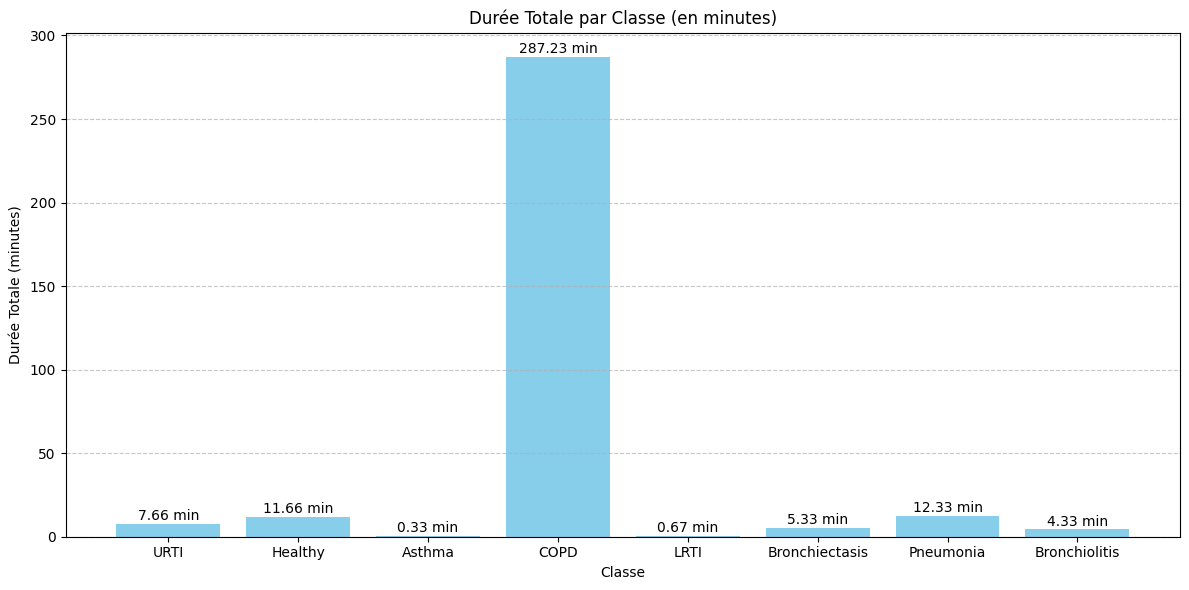

In [5]:
labels = list(durations.keys())
total_durations = list(durations.values())
total_durations_in_minutes = [d / 60 for d in total_durations]

# Plotting the results
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, total_durations_in_minutes, color='skyblue')

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.2f} min", ha='center', va='bottom')

# Titres et labels
plt.xlabel('Classe')
plt.ylabel('Durée Totale (minutes)')
plt.title('Durée Totale par Classe (en minutes)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Afficher le graphique
plt.show()

Notre situation ici est très désiquilibrée il faut trouver un moyen pour équilibrer les classes sachant qu'on ne peut pas trouver d'autres datasets pour enrichir la notre
Augmenter  la durée minimale de  classes jusqu'elle soient plus équilibrées au moins ~10 minutes pour se rapprocher de lma médiane.

| Class          | Current (min) | Needed (min) | Target Multiplier |
| -------------- | ------------- | ------------ | ----------------- |
| Asthma         | 0.33          | 10           | \~30x             |
| LRTI           | 0.67          | 10           | \~15x             |
| Bronchiolitis  | 4.33          | 10           | \~2.5x            |
| Bronchiectasis | 5.33          | 10           | \~2x              |
| URTI           | 7.66          | 10           | \~1.3x            |


# Targeted Data Augmentation 

In [8]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5)
])


def augment_audio(file_path, output_dir, num_augmented):
    y, sr = librosa.load(file_path, sr=None)
    for i in range(num_augmented):
        augmented = augment(samples=y, sample_rate=sr)
        out_path = os.path.join(output_dir, f"{os.path.basename(file_path).split('.')[0]}_aug_{i}.wav")
        sf.write(out_path, augmented, sr)


In [9]:
label_counts

label
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: count, dtype: int64

In [23]:
nums_augment={
    'Asthma':60,
    'Healthy':2,
    'Pneumonia':2,
    'LRTI':10,
    'Bronchiolitis':6,
    'Bronchiectasis':4,
    'URTI':4}

In [27]:
augmented_tobe=['Asthma','Healthy','Pneumonia','LRTI','Bronchiolitis','Bronchiectasis','URTI']

In [25]:
for _, row in annotations.iterrows():
    prefix= str(row['id'])
    matching_files = []
    
    for root, dirs, files in os.walk(DATA_PATH):
        for file in files:
            if file.endswith('.wav') and file.startswith(prefix):
                matching_files.append(os.path.join(root, file))
    for file in matching_files:
        # Vérifier que le fichier existe
        if  os.path.exists(file) and row['label'] in augmented_tobe :
            try:
                augment_audio(file, DATA_PATH, nums_augment[row['label']])
            except Exception as e:
                print(f"Erreur avec le fichier {file}: {e}")

KeyboardInterrupt: 

In [33]:
from collections import defaultdict
# Dictionnaire pour accumuler les durées
durations = defaultdict(float)

# Itérer sur toutes les lignes
for _, row in annotations.iterrows():
    prefix= str(row['id'])
    matching_files = []
    
    for root, dirs, files in os.walk(DATA_PATH):
        for file in files:
            if file.endswith('.wav') and file.startswith(prefix):
                matching_files.append(os.path.join(root, file))
    for file in matching_files:
        # Vérifier que le fichier existe
        if os.path.exists(file):
            try:
                # Charger l'audio pour obtenir la durée
                audio, sr = librosa.load(file, sr=None)
                duration = librosa.get_duration(y=audio, sr=sr)
                # Ajouter à la classe correspondante
                durations[row['label']] += duration
            except Exception as e:
                print(f"Erreur avec le fichier {file}: {e}")

# Afficher les durées totales par classe
for label, total_duration in durations.items():
    print(f"Classe '{label}' : {total_duration:.2f} secondes ({total_duration / 60:.2f} minutes)")

Classe 'URTI' : 2298.25 secondes (38.30 minutes)
Classe 'Healthy' : 2098.62 secondes (34.98 minutes)
Classe 'Asthma' : 1220.00 secondes (20.33 minutes)
Classe 'COPD' : 17233.84 secondes (287.23 minutes)
Classe 'LRTI' : 1480.00 secondes (24.67 minutes)
Classe 'Bronchiectasis' : 1600.00 secondes (26.67 minutes)
Classe 'Pneumonia' : 2220.00 secondes (37.00 minutes)
Classe 'Bronchiolitis' : 1820.00 secondes (30.33 minutes)


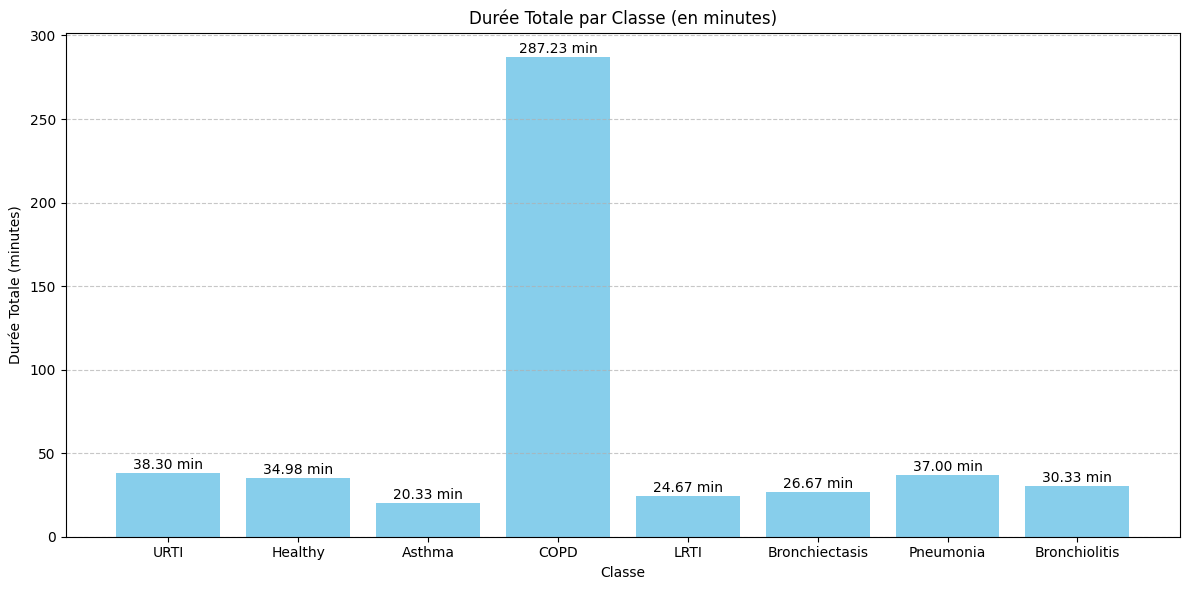

In [34]:
labels = list(durations.keys())
total_durations = list(durations.values())
total_durations_in_minutes = [d / 60 for d in total_durations]

# Plotting the results
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, total_durations_in_minutes, color='skyblue')

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.2f} min", ha='center', va='bottom')

# Titres et labels
plt.xlabel('Classe')
plt.ylabel('Durée Totale (minutes)')
plt.title('Durée Totale par Classe (en minutes)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Afficher le graphique
plt.show()

# Breath Enhancement filter

In [36]:
import numpy as np
import pywt
import librosa
import soundfile as sf

def wavelet_denoise(input_file, output_file, wavelet='db4', level=2):
    # Load audio file
    data, sr = librosa.load(input_file, sr=None)
    
    # Step 1: Wavelet decomposition
    coeffs = pywt.wavedec(data, wavelet, level=level)

    # Step 2: Estimate universal threshold
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))

    # Step 3: Apply thresholding to detail coefficients
    coeffs_thresh = [coeffs[0]]  # Keep approximation coefficients as-is
    for detail in coeffs[1:]:
        coeffs_thresh.append(pywt.threshold(detail, value=uthresh, mode='soft'))

    # Step 4: Reconstruct signal
    denoised_data = pywt.waverec(coeffs_thresh, wavelet)

    # Step 5: Save result
    sf.write(output_file, denoised_data, sr)
    print(f"Denoised file saved to: {output_file}")


In [38]:
wavelet_denoise(os.path.join(DATA_PATH,'103_2b2_Ar_mc_LittC2SE.wav'), "output_denoised2.wav")


Denoised file saved to: output_denoised2.wav


In [41]:
# Traverse all .wav files
for root, dirs, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith('.wav'):
            input_file = os.path.join(root, file)
            output_file = os.path.join(PREPROCESSED_DATA_PATH, file)
            
            if os.path.exists(input_file):
                try:
                    wavelet_denoise(input_file, output_file)
                except Exception as e:
                    print(f"Erreur avec le fichier {input_file}: {e}")


Denoised file saved to: ./ICBHI_final_database_preprocessed\101_1b1_Al_sc_Meditron.wav
Denoised file saved to: ./ICBHI_final_database_preprocessed\101_1b1_Al_sc_Meditron_aug_0.wav
Denoised file saved to: ./ICBHI_final_database_preprocessed\101_1b1_Al_sc_Meditron_aug_1.wav
Denoised file saved to: ./ICBHI_final_database_preprocessed\101_1b1_Al_sc_Meditron_aug_2.wav
Denoised file saved to: ./ICBHI_final_database_preprocessed\101_1b1_Al_sc_Meditron_aug_3.wav
Denoised file saved to: ./ICBHI_final_database_preprocessed\101_1b1_Pr_sc_Meditron.wav
Denoised file saved to: ./ICBHI_final_database_preprocessed\101_1b1_Pr_sc_Meditron_aug_0.wav
Denoised file saved to: ./ICBHI_final_database_preprocessed\101_1b1_Pr_sc_Meditron_aug_1.wav
Denoised file saved to: ./ICBHI_final_database_preprocessed\101_1b1_Pr_sc_Meditron_aug_2.wav
Denoised file saved to: ./ICBHI_final_database_preprocessed\101_1b1_Pr_sc_Meditron_aug_3.wav
Denoised file saved to: ./ICBHI_final_database_preprocessed\102_1b1_Ar_sc_Meditron

# Number of files

In [23]:
# Dictionnaire pour accumuler le nombre de fichiers
file_counts = defaultdict(int)

# Itérer sur toutes les lignes du DataFrame `annotations`
for _, row in annotations.iterrows():
    prefix = str(row['id'])
    matching_files = []

    for root, dirs, files in os.walk(DATA_PATH):
        for file in files:
            if file.endswith('.wav') and file.startswith(prefix):
                matching_files.append(os.path.join(root, file))

    for file in matching_files:
        if os.path.exists(file):
            file_counts[row['label']] += 1

# Afficher le nombre de fichiers par classe
for label, count in file_counts.items():
    print(f"Classe '{label}' : {count} fichiers")


Classe 'URTI' : 115 fichiers
Classe 'Healthy' : 105 fichiers
Classe 'Asthma' : 61 fichiers
Classe 'COPD' : 793 fichiers
Classe 'LRTI' : 74 fichiers
Classe 'Bronchiectasis' : 80 fichiers
Classe 'Pneumonia' : 111 fichiers
Classe 'Bronchiolitis' : 91 fichiers


# Data Normalisation

In [10]:
for root, dirs, files in os.walk(PREPROCESSED_DATA_PATH):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)

            # Load audio file
            y, sr = librosa.load(file_path, sr=None)

            # Normalize: divide by the max absolute value
            if y.size > 0:
                y_norm = y / max(1e-8, abs(y).max())  # Prevent division by zero

                # Overwrite the original file (or save somewhere else)
                sf.write(os.path.join(PREPROCESSED_NORMALIZED_DATA_PATH, file), y_norm, sr)

print("✅ Normalization completed for all .wav files.")


KeyboardInterrupt: 